# PETITE BSM shower generation example

PETITE is a simple, lightweight, toy Monte Carlo that generates realistic electromagnetic showers. 

Authors: Kevin J. Kelly (Texas A&M), Nikita Blinov (U. Victoria), Ryan Plestid (Caltech), Patrick J. Fox (Fermilab), and Pedro A.M. Machado (Fermilab)

It includes explicit simulation of (we denote nuclei by their electric charge $Z$)

* Bremsstrahlung  $e^\pm Z \rightarrow e^\pm \gamma Z$. 
* Pair production $\gamma Z \rightarrow e^+ e^- Z$. 
* Compton scattering $\gamma e^- \rightarrow  \gamma e^-$
* Pair-annihilation $e^+ e^- \rightarrow \gamma\gamma$ 

and implicit simulation of 

* Multiple Coulomb scattering
* Energy loss by ionization 

${\bf Dependencies}$: numpy, vegas, pickle, cProfile, tqdm, scipy

${\bf Version~ requirements}$: numpy 1.24  ,  python3.xx with xx$\geq$9.

${\bf Directory~structure}$: This notebook assumes that within a PETITE home directory there is folder containing dictionaries, and that within that folder the following files exist 

* $\verb|<PETITE_home_dir>|$/$\verb|<dictionary_dir>|$/Feb13_xSec_Dicts.pkl
* $\verb|<PETITE_home_dir>|$/$\verb|<dictionary_dir>|$/Mar24_xSec_Dicts.pkl
* $\verb|<PETITE_home_dir>|$/$\verb|<dictionary_dir>|$/Mar24_xSec_Dicts_neval.pkl

You can check versions with the code below and adjust if necessary

In [1]:
from platform import python_version
print("Python version: ", python_version())

import numpy
print("Numpy version: ", numpy.__version__)

import os
current_path = os.getcwd()
PETITE_home_dir= current_path.split('examples')[0]

print("PETITE home directory:", PETITE_home_dir)

dictionary_dir = "frozencode/"

Python version:  3.10.6
Numpy version:  1.22.4
PETITE home directory: /Users/kjkelly/Library/CloudStorage/Dropbox/GitHub/PETITE/


### Load in dependencies and set font styles

In [2]:
#from kjkutils import *
from PETITE.dark_shower import *
import pickle as pk
from matplotlib import pyplot as plt
from tqdm import tqdm
import matplotlib

from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FixedLocator, MaxNLocator
import cProfile
profile = cProfile.Profile()
import pstats

font0 = FontProperties()
font = font0.copy()
font.set_size(24)
font.set_family('serif')
labelfont=font0.copy()
labelfont.set_size(20)
labelfont.set_weight('bold')
legfont=font0.copy()
legfont.set_size(18)
legfont.set_weight('bold')


def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

####  Import two shower objects, one with a graphite target and one with lead. Both track down to minimum energies of 10 MeV

The minimum energy in the shower dictates the run-time. As one attempts to simulate lower-threshold IR physics, the computational cost increases exponentially. The number of low energy particles proliferates and one encounters many compton scatters.  10 MeV allows for reasonable simulation speed. 

Pre-loaded materials are lead and graphite, but other materials can be included straightforwardly running other scripts in the PETITE utilities folder

In [3]:
sGraphite = DarkShower(PETITE_home_dir+dictionary_dir, "graphite", 0.030, 0.0323)

Weights not previously calculated, calculating now...


/Users/kjkelly/Documents/miniforge3/envs/kjk/lib/python3.10/site-packages/PETITE/shower.py:248: RuntimeWarning: overflow encountered in exp
  return np.exp(-n_sigma_diff/dEdxT/cmtom)


dRate not previously calculated, calculating now...


/Users/kjkelly/Documents/miniforge3/envs/kjk/lib/python3.10/site-packages/PETITE/shower.py:281: RuntimeWarning: divide by zero encountered in double_scalars
  return cmtom*(self._NSigmaBrem(Energy) + self._NSigmaAnn(Energy) + self._NSigmaBhabha(Energy))**-1


In [4]:
print(sGraphite._mV_list)
print(sGraphite._mV)
print(sGraphite._mV_estimator)

[0.003, 0.01, 0.03, 0.1, 0.3, 1.0]
0.03
0.03


In [5]:
sGraphite._loaded_dark_samples['DarkBrem'][10][1]['max_F']

{'graphite': 0.003569273891322908,
 'lead': 0.6556100791861486,
 'iron': 0.06691471638760231}

In [6]:
list(sGraphite.draw_dark_sample(20.0, 50, "DarkBrem"))

[0.16581194326626736, -4.706668458047405, -8.827995833392768]

In [8]:
p0 = pickle.load(open(PETITE_home_dir+dictionary_dir+"/dark_xsec.pkl", "rb"))[sGraphite._mV_estimator]['DarkBrem']['graphite']

Text(0, 0.5, '$\\sigma_{\\rm dark\\ brem.}\\ [\\mathrm{GeV}^{-2}]$')

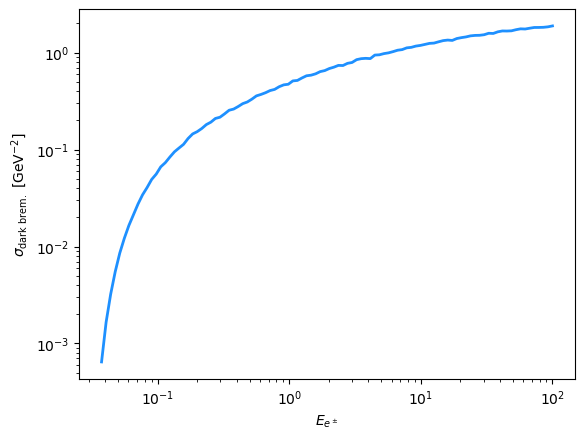

In [9]:
sX, sY = np.transpose(p0)
plt.plot(sX, sY, lw=2, color='dodgerblue')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$E_{e^\pm}$")
plt.gca().set_ylabel(r"$\sigma_{\rm dark\ brem.}\ [\mathrm{GeV}^{-2}]$")

In [10]:
ntrials = []
xs = []
for k in tqdm(range(100000)):
    s0 = sGraphite.draw_dark_sample(1.0, process="DarkAnn", VB=True)
    xs.append([s0[0], s0[1]])
    ntrials.append(s0[-1])

100%|██████████| 100000/100000 [00:12<00:00, 8263.66it/s]


In [11]:
np.max(ntrials)

10.0

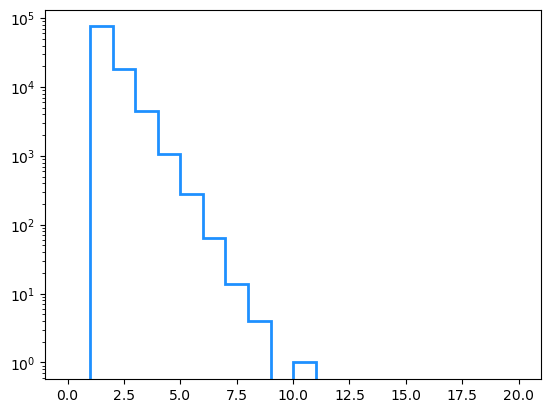

In [13]:
plt.hist(ntrials, bins=np.linspace(0, 20, 21), histtype='step', lw=2, color='dodgerblue')
plt.gca().set_yscale('log')

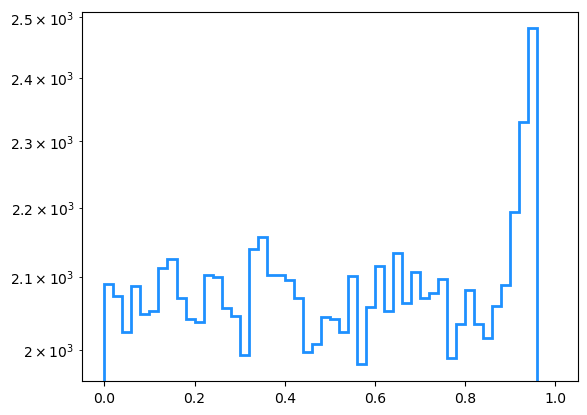

In [14]:
plt.hist(np.transpose(xs)[0], bins=np.linspace(0, 1, 51), histtype='step', lw=2, color='dodgerblue')
plt.gca().set_yscale('log')

In [15]:
s_test = 2.0*0.000511*(0.000511 + 1.0)
alpha_test = 1/137.0
beta = (2.*alpha_test/np.pi)*(np.log(s_test/0.000511**2) - 1.)

x_array = 1 - np.power(np.transpose(xs)[0], 2./beta)

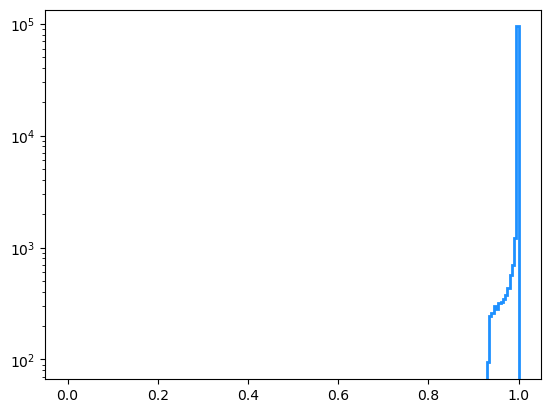

In [16]:
plt.hist(x_array, bins=np.linspace(0, 1, 201), histtype='step', lw=2, color='dodgerblue')
plt.gca().set_yscale('log')

/var/folders/f7/2f10v0150kq5wjxpbj74ph000000gp/T/ipykernel_56171/2871372156.py:2: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.gca().set_yscale('log')


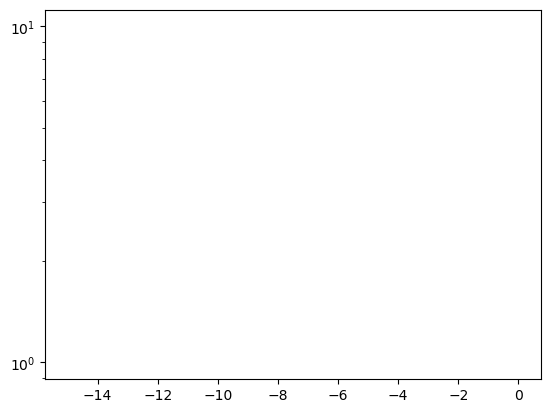

In [17]:
plt.hist(np.transpose(xs)[1], bins=np.linspace(-15,0, 201), histtype='step', lw=2, color='dodgerblue')
plt.gca().set_yscale('log')

In [20]:
sGraphite._resonant_annihilation_energy

0.8801170336516327

In [23]:
(sGraphite.get_DarkAnnXSec()[0][0]-sGraphite._resonant_annihilation_energy)/sGraphite._resonant_annihilation_energy

9.99999999999768e-05

In [19]:
sGraphite._minimum_calculable_dark_energy

{11: {'DarkBrem': 0.0375},
 -11: {'DarkBrem': 0.0375, 'DarkAnn': 0.8801170336516327},
 22: {'DarkComp': 0.9107190954048927},
 111: {'TwoBody_BSMDecay': -1}}

In [29]:
Energies, Weights = {}, {}
parent_pid_options = [11, -11, 22]
for pr in dark_process_codes:
    Energies[pr] = {}
    Weights[pr] = {}
    for pid in parent_pid_options:
        Energies[pr][pid] = []
        Weights[pr][pid] = []

for kk in tqdm(range(100)):
    p0 = [10, 0, 0, 10]
    r0 = [0, 0, 0]
    pdict = {"PID":22}
    part0 = Particle(p0, r0, pdict)
    s0SM = sGraphite.generate_shower(part0)
    s0BSM = sGraphite.generate_dark_shower(ExDir=list(s0SM));
    for p0 in s0BSM[1]:   
        genprocess = p0.get_ids()["generation_process"]
        parent_pid = p0.get_ids()["parent_PID"]

        Energies[genprocess][parent_pid].append(p0.get_p0()[0])
        Weights[genprocess][parent_pid].append(p0.get_ids()["weight"])

100%|██████████| 100/100 [03:13<00:00,  1.94s/it]


In [30]:
len(s0SM), len(s0BSM[1])

(446, 334)

In [31]:
log_bins_0 = np.logspace(-2, 2, 41)
def bin_width(energy, bins=log_bins_0):
    index = np.abs(bins - energy).argmin()
    return bins[index+1] - bins[index]

Text(0.5, 0, '$E_V\\ [\\mathrm{GeV}]$')

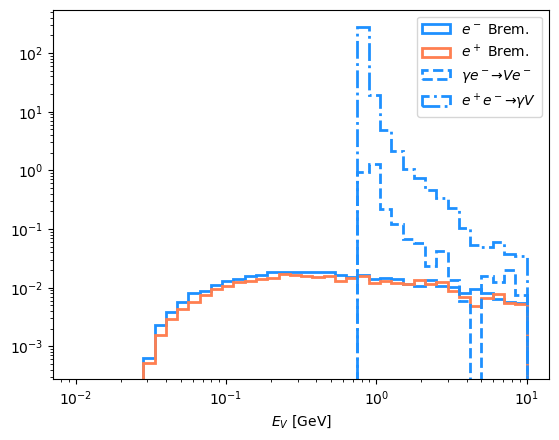

In [32]:
plt.hist(Energies['DarkBrem'][11], weights=Weights['DarkBrem'][11], bins=np.logspace(-2, 1, 41), histtype='step', lw=2, color='dodgerblue', label=r"$e^-\ \mathrm{Brem.}$")
plt.hist(Energies['DarkBrem'][-11], weights=Weights['DarkBrem'][-11], bins=np.logspace(-2, 1, 41), histtype='step', lw=2, color='coral', label=r"$e^+\ \mathrm{Brem.}$")
plt.hist(Energies['DarkComp'][22], weights=Weights['DarkComp'][22], bins=np.logspace(-2, 1, 41), histtype='step', lw=2, ls='--', color='dodgerblue', label=r"$\gamma e^- \to V e^-$")
plt.hist(Energies['DarkAnn'][-11], weights=Weights['DarkAnn'][-11], bins=np.logspace(-2, 1, 41), histtype='step', lw=2, ls='-.', color='dodgerblue', label=r"$e^+ e^- \to \gamma V$")
plt.legend(loc='best')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$E_V\ [\mathrm{GeV}]$")

In [11]:
plt.savefig("/Users/kjkelly/Dropbox/DarkVFlux.pdf", bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

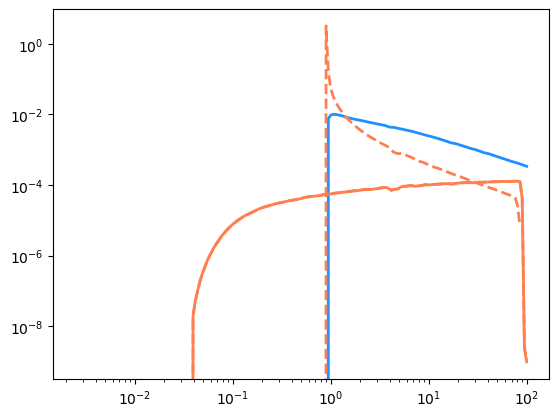

In [33]:
energyvec = np.logspace(-2.6, 2, 201)
plt.plot(energyvec, [sGraphite.GetBSMWeights([22, ee], "DarkComp") for ee in energyvec], lw=2, color='dodgerblue')
plt.plot(energyvec, [sGraphite.GetBSMWeights([11, ee], "DarkBrem") for ee in energyvec], lw=2, color='coral')
plt.plot(energyvec, [sGraphite.GetBSMWeights([-11, ee], "DarkBrem") for ee in energyvec], lw=2, ls='--', color='coral')
plt.plot(energyvec, [sGraphite.GetBSMWeights([-11, ee], "DarkAnn") for ee in energyvec], lw=2, ls='--', color='coral')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')